## Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Nadam
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
#nltk.download("stopwords")
#nltk.download("wordnet")
%matplotlib inline

## Display data

In [2]:
train_df = pd.read_csv("./input/train.csv")
train_df = train_df.fillna("empty")
train_df = train_df.drop(["id", "qid1", "qid2"], axis = 1)
train_df.head(10)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


Text(0.5, 1.0, 'Class proportions')

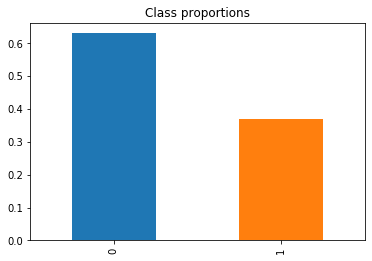

In [3]:
(train_df["is_duplicate"].value_counts() / len(train_df)).plot("bar")
plt.title("Class proportions")

In [4]:
test_df = pd.read_csv("./input/test.csv")
test_df = test_df.fillna("empty")

## Preprocess text sequences

In [5]:
def text_to_wordlist(text):
    """Clean the text, remove stop words and stem words."""
    
    # --------- Convert to lower case, replace chars and split to list ---------
    text = text.lower()
    text = text.replace("\\", " ")
    text = text.replace("/", " ")
    text = re.sub("[\][_.,:;!?+=*~#$%&(){}|<>@^`“”]", "", text)
    text = text.split(" ")
    
    # --------- Remove stop words ---------
    #stop_words = set(stopwords.words("english"))
    #text = [word
    #        for word in text
    #        if not word in stop_words]    
    
    # --------- Lemmatize words ---------
    #lemmatizer = WordNetLemmatizer() 
    #text = [lemmatizer.lemmatize(word) for word in text] 
    
    # --------- Shorten words to their stems ---------
    stemmer = SnowballStemmer("english")
    text = [stemmer.stem(word) for word in text]
    
    # --------- Return list of words ---------    
    return(text)

def process_questions(input_list):
    """Preprocess questions creating a list (of word lists)"""
    output_list = []
    for question in input_list:
        output_list.append(text_to_wordlist(question))
    return output_list

In [6]:
questions_1_train = process_questions(train_df["question1"])
questions_2_train = process_questions(train_df["question2"])

labels_train = np.array(train_df["is_duplicate"])

print(f"Found {len(labels_train)} texts in training data")

Found 404290 texts in training data


In [8]:
questions_1_test = process_questions(test_df["question1"])
questions_2_test = process_questions(test_df["question2"])

ids_test = test_df["test_id"] # need only for submission

print(f"Found {len(ids_test)} texts in test data")

Found 2345796 texts in test data


In [7]:
# --------- Check results of preprocessing ---------
for i in range(5):
    print(f"{i}: {questions_1_train[i]}")

0: ['what', 'is', 'the', 'step', 'by', 'step', 'guid', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']
1: ['what', 'is', 'the', 'stori', 'of', 'kohinoor', 'koh-i-noor', 'diamond']
2: ['how', 'can', 'i', 'increas', 'the', 'speed', 'of', 'my', 'internet', 'connect', 'while', 'use', 'a', 'vpn']
3: ['whi', 'am', 'i', 'mental', 'veri', 'lone', 'how', 'can', 'i', 'solv', 'it']
4: ['which', 'one', 'dissolv', 'in', 'water', 'quik', 'sugar', 'salt', 'methan', 'and', 'carbon', 'di', 'oxid']


In [9]:
# --------- Create vocabulary index based on word frequency ---------
tokenizer = Tokenizer(num_words = 200_000) # 200K is the maximum number of words to keep
tokenizer.fit_on_texts(questions_1_train + questions_2_train + questions_1_test + questions_2_test)

# --------- Transform each text to a vector of integers ---------
questions_1_train = tokenizer.texts_to_sequences(questions_1_train)
questions_2_train = tokenizer.texts_to_sequences(questions_2_train)
questions_1_test = tokenizer.texts_to_sequences(questions_1_test)
questions_2_test = tokenizer.texts_to_sequences(questions_2_test)

word_index = tokenizer.word_index

print(f"Found {len(word_index)} unique tokens in data")

Found 131073 unique tokens in data


In [12]:
# --------- Explore the dictionary of tokens ---------

# Every word gets an integer value. Lower value means more frequent word. 0 is reserved for padding.
for word, i in word_index.items(): 
    if (i <= 10) or (len(word_index)-30 < i < len(word_index)-17):
        print(f"{i}: {word}")

1: the
2: what
3: is
4: how
5: i
6: a
7: in
8: to
9: of
10: do
131044: gustafsson
131045: snapdealyesterday
131046: lacon
131047: low”
131048: cronyism
131049: coldplaythey
131050: kicad
131051: schemet
131052: cvpcb
131053: geostrategi
131054: lothar
131055: matthaus


In [13]:
# Now the questions are (1, num_words) vectors
questions_1_train[0:4]

[[2, 3, 1, 727, 62, 727, 2225, 8, 268, 7, 532, 213, 7, 35],
 [2, 3, 1, 369, 9, 12516, 18733, 3070],
 [4, 13, 5, 273, 1, 460, 9, 18, 372, 519, 176, 34, 6, 2575],
 [15, 72, 5, 1244, 307, 2675, 4, 13, 5, 562, 17]]

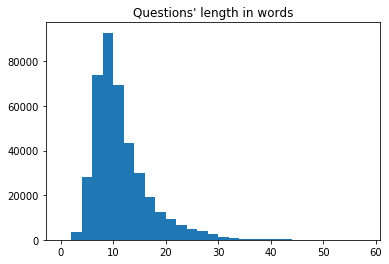

In [14]:
len_questions = [len(q) for q in questions_1_train]

plt.hist(len_questions, bins = np.arange(0, 60, 2))
plt.title("Questions' length in words")
plt.show()

In [ ]:
# --------- Fix length of questions to 30 words ---------
max_len = 30

questions_1_train = pad_sequences(questions_1_train, maxlen = 30)
questions_2_train = pad_sequences(questions_2_train, maxlen = 30)

questions_1_test = pad_sequences(questions_1_test, maxlen = 30)
questions_2_test = pad_sequences(questions_2_test, maxlen = 30)

In [16]:
# Now the questions are (1, 30) vectors
questions_1_train[0:4, :]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     2,     3,
            1,   727,    62,   727,  2225,     8,   268,     7,   532,
          213,     7,    35],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     2,     3,     1,   369,     9,
        12516, 18733,  3070],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     4,    13,
            5,   273,     1,   460,     9,    18,   372,   519,   176,
           34,     6,  2575],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    15,    72,     5,  1244,   307,  2675,     4,    13,
            5,   562,    17]], dtype=int32)

## Get embeddings from GloVe

The embedding text file has ~2.2M lines. Each line is a word followed by 300 coefficients, for example: "and -0.18567 0.066008 -0.25209 -0.11725 0.26513 0.064908 0.12291..."

In [17]:
embeddings_dict = {}

# --------- Save word vectors ---------
with open("./input/glove.840B.300d.txt", encoding = "utf8") as file:
    for line in file:
        parts = line.split()
        # Get word and its coefs
        try:
            word = parts[0]
            coefs = np.asarray(parts[1:], dtype = "float32")        
        except:
            pass
        # Save to dict if shape is correct
        if coefs.shape == (300,):
            embeddings_dict[word] = coefs   

print(f"Found {len(embeddings_dict.values())} valid word vectors")

Found 2195875 valid word vectors


In [18]:
num_words = min(200_000, len(word_index))
embed_size = 300

# Zero init for words not in GloVe
embedding_matrix = np.zeros((num_words, embed_size))

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (131073, 300)


In [19]:
# --------- Search for embeddings from GloVe ---------
num_found = 0
for word, i in word_index.items(): # iterate over words found in data
    if i >= num_words: 
        continue # if words found in data > vocab size: skip iteration
    embedding_vector = embeddings_dict.get(word) # search for embedding from dict
    if embedding_vector is not None:
        num_found += 1
        embedding_matrix[i] = embedding_vector # save vector to embedding matrix
        
print(f"Found embedding for {num_found} words")

Found embedding for 54984 words


## Split data

In [32]:
train_size = 0.85

# --------- Create shuffled list of indices ---------
perm = np.random.permutation(len(questions_1_train))

# --------- Set 85 % of those as train and rest as val ---------
idx_train = perm[:int(len(questions_1_train)*train_size)]
idx_val = perm[int(len(questions_1_train)*train_size):]

# Input 1
x_1_train = questions_1_train[idx_train]
x_1_val = questions_1_train[idx_val]

# Input 2
x_2_train = questions_2_train[idx_train]
x_2_val = questions_2_train[idx_val]

# Targets
y_train = labels_train[idx_train]
y_val = labels_train[idx_val]

print(f"Shape of training data: {x_1_train.shape}")
print(f"Shape of validation data: {x_1_val.shape}")

Shape of training data: (343646, 30)
Shape of validation data: (60644, 30)


## Specify model

In [ ]:
embedding_layer = Embedding(
    num_words,
    embed_size,
    weights = [embedding_matrix],
    input_length = max_len,
    trainable = False
)

lstm_layer = LSTM(
    350,
    dropout = 0.2,
    recurrent_dropout = 0.2
)

x_1_inp = Input(shape = (30,), dtype = "int32")
x_1 = embedding_layer(x_1_inp)
x_1 = lstm_layer(x_1)

x_2_inp = Input(shape = (30,), dtype = "int32")
x_2 = embedding_layer(x_2_inp)
x_2 = lstm_layer(x_2)

x = concatenate([x_1, x_2])
x = Dropout(0.2)(x)
x = Dense(250, activation = "relu")(x)
x = Dropout(0.2)(x)
x = Dense(125, activation = "relu")(x)
x = Dropout(0.2)(x)
x = Dense(1, activation = "sigmoid")(x)
  
model = Model(inputs = [x_1_inp, x_2_inp], outputs = x)

model.compile(
    loss = "binary_crossentropy",
    optimizer = Nadam(lr = 2e-3, beta_1 = 0.9, beta_2 = 0.999),
    metrics = ["acc"]
)

## Fit model

In [40]:
callbacks_list = [
    EarlyStopping(monitor = "val_loss", patience = 3),
    ModelCheckpoint("model.h5", save_best_only = True, save_weights_only = True)
]

fit_log = model.fit(
    [x_1_train, x_2_train],
    y_train,
    validation_data = ([x_1_val, x_2_val], y_val),
    epochs = 50,
    batch_size = 1024,
    shuffle = True,
    callbacks = callbacks_list
)

Instructions for updating:
Use tf.cast instead.
Train on 343646 samples, validate on 60644 samples
Epoch 1/50
343646/343646 [==============================] - 47s 136us/step - loss: 0.5463 - acc: 0.7155 - val_loss: 0.4730 - val_acc: 0.7641
Epoch 2/50
343646/343646 [==============================] - 45s 131us/step - loss: 0.4629 - acc: 0.7711 - val_loss: 0.4311 - val_acc: 0.7925
Epoch 3/50
343646/343646 [==============================] - 45s 131us/step - loss: 0.4242 - acc: 0.7954 - val_loss: 0.4104 - val_acc: 0.8039
Epoch 4/50
343646/343646 [==============================] - 45s 132us/step - loss: 0.3955 - acc: 0.8120 - val_loss: 0.3921 - val_acc: 0.8165
Epoch 5/50
343646/343646 [==============================] - 45s 132us/step - loss: 0.3715 - acc: 0.8258 - val_loss: 0.3949 - val_acc: 0.8128
Epoch 6/50
343646/343646 [==============================] - 45s 132us/step - loss: 0.3519 - acc: 0.8368 - val_loss: 0.3764 - val_acc: 0.8251
Epoch 7/50
343646/343646 [=============================

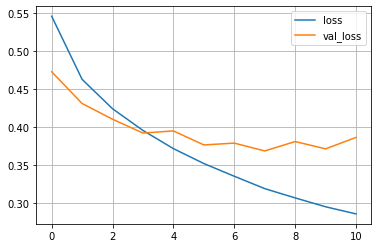

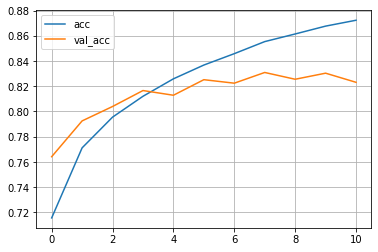

In [41]:
fit_log_df = pd.DataFrame(fit_log.history)

fit_log_df[["loss", "val_loss"]].plot()
plt.grid()

fit_log_df[["acc", "val_acc"]].plot()
plt.grid()

## Predict

In [42]:
model.load_weights("model.h5")

preds = model.predict(
    [questions_1_test, questions_2_test],
    batch_size = 2048,
    verbose = 1
)

2345796/2345796 [==============================] - 108s 46us/step


In [43]:
submission = pd.DataFrame({"test_id": ids_test, "is_duplicate": preds.squeeze()})
submission.to_csv("submission.csv", index = False)